In [1]:
from jax.config import config

config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import jit
from jax.config import config
import jax.numpy as jnp
from jax.lax import erf
import jax.random as jr
from typing import List, Union
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from jax import vmap
from gpjax.kernels import ProductKernel
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from matplotlib import rcParams
from gpjax.base import param_field, static_field
import matplotlib.pyplot as plt
import optax as ox
import pandas as pd
import tensorflow_probability as tfp
from jaxtyping import Float, Num
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(12345)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


I0000 00:00:1695921596.172881   12154 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


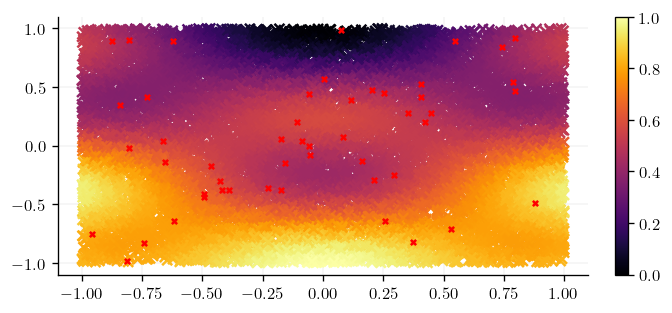

In [2]:
n = 50
d=2
noise = jnp.sqrt(0.01)
# key, subkey = jr.split(key)

def f(x):
    x_1 = x[:,0:1]
    x_2 = x[:,1:2]
    return (x_1**2 - 2*x_2 + jnp.cos(3*x_1)*jnp.sin(5*x_2))


#x = jr.normal(key=key, shape=(n,d))
x = jr.uniform(key=key, shape=(n,d), minval=-1.0, maxval=1.0)   
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

n_plot = 10_000
xplot = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_plot,d))
yplot = f(xplot)
plt.scatter(xplot[:,0], xplot[:,1], c=yplot)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

n_test = 1_000
xtest = jr.uniform(key=key, minval=-1.0, maxval=1.0, shape=(n_test,d))


In [9]:

@dataclass
class ConstantKernel(gpx.kernels.AbstractKernel):
    variance: ScalarFloat = param_field(1.0, bijector=tfb.Softplus())

    def __call__(self, x, y):
        return self.variance




# @dataclass
# class RBFOrthogonalKernel(gpx.kernels.AbstractKernel):
#     lengthscale: Float[Array, " D"] = param_field(
#         jnp.array(1.0), bijector=tfb.Softplus()
#     )
#     input_measure: tfd.Distribution= static_field(tfd.Uniform(low=-1.0, high=1.0))

#     def __post_init__(self):
#         assert isinstance(self.input_measure, Union[tfd.Normal, tfd.Uniform])

#     def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
#         return jnp.prod(self._eval_sub_kernels(x, y))
      
#     def _eval_sub_kernels(self,x: Num[Array, " D"], y: Num[Array, " D"] ) -> Num[Array, " D"]:
#         x = self.slice_input(x) / self.lengthscale # [d]
#         y = self.slice_input(y) / self.lengthscale # [d]
#         dists = (x - y) ** 2  # [d]
#         ks = jnp.exp(-0.5 * dists) # [d]
#         ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
#         return ks # [d]
    
#     def _cov_x_s(self,x):
#         l = self.lengthscale
#         if isinstance(self.input_measure, tfd.Normal):
#             mean, var = self.input_measure.loc, self.input_measure.scale**2
#             return var * jnp.sqrt(l**2 / (l**2 + var)) * jnp.exp(-0.5 * (x - mean) ** 2 / (l**2 + var)) # [d]
#         elif isinstance(self.input_measure, tfd.Uniform):
#             a, b = self.input_measure.low, self.input_measure.high
#             upper = (b - x) / jnp.sqrt(2.0) / l
#             lower = (a - x) / jnp.sqrt(2.0) / l
#             return (l / (b-a)) * jnp.sqrt(jnp.pi/2.0) * (erf(upper) - erf(lower))

#     def _var_s(self):
#         l = self.lengthscale
#         if isinstance(self.input_measure, tfd.Normal):
#             mean, var = self.input_measure.loc, self.input_measure.scale**2
#             return var * jnp.sqrt(l**2 / (l**2 + 2.0*var))# [d]

#         elif isinstance(self.input_measure, tfd.Uniform):
#             a, b = self.input_measure.low, self.input_measure.high
#             y = (b-a) / jnp.sqrt(2.0) / l   
#             v = 2.0 * (l**2) /( (b-a)**2)
#             v *= jnp.sqrt(jnp.pi) * y * erf(y)  + jnp.exp(-y**2) - 1.0
#             return v

# @dataclass()
# class OrthogonalAdditiveKernel(gpx.kernels.AbstractKernel): 
#     base_kernel: RBFOrthogonalKernel =  RBFOrthogonalKernel()
#     max_interaction_depth: ScalarInt = static_field(1)
#     interaction_variances: Num[Array, " p"] = param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus()) # for constant term   


#     def __post_init__(self):
#         assert self.max_interaction_depth == len(self.interaction_variances)-1

#         self.kernels = []
#         for dim in range(len(active_dims)):


#     def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
#         r"""Compute the RBF OAK kernel between a pair of arrays.
#         WE ASSUME THAT THE INPUT DIST IS N(0,1)
#         """
#         x = self.slice_input(x) # [d]
#         y = self.slice_input(y) # [d]
#         ks = self.base_kernel._eval_sub_kernels(x, y) # [d]
#         return jnp.dot(self.compute_additive_terms_girad_newton(ks), self.interaction_variances)

       
#     @jit   
#     def compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
#         r"""Given a list of inputs, compute a new list containing all products up to order
#         `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
#         (i.e. O(d^2) instead of exponential).
#         """

#         ks = ks[None, :] # [1, d]
#         powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
#         s = jnp.power(ks,powers) # [p+1, d]
#         e = jnp.zeros(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
#         e = e.at[0].set(1.0) # start with constant term
#         for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
#             thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
#             e = e.at[n].set((1.0/n) *jnp.sum(thing))
#         return jnp.array(e) # [max_interaction_depth + 1]
    

#     def return_specific_contribution(self, iComponent_list: List[int] = [0]) -> gpx.kernels.AbstractKernel:
        
#         kernel = ConstantKernel(variance = self.interaction_variances[len(iComponent_list)])

#         if len(iComponent_list)>0:
#             sliced_lengthscale = self.base_kernel.lengthscale[..., iComponent_list] if self.base_kernel.lengthscale.ndim > 0 else self.base_kernel.lengthscale
#             kernel *=RBFOrthogonalKernel(active_dims=iComponent_list, lengthscale=sliced_lengthscale)
        
#         return kernel
 

  




@dataclass()
class OrthogonalKernel(gpx.kernels.AbstractKernel):
    base_kernel: gpx.kernels.AbstractKernel = None
    input_samples: Num[Array, " S, d"] = static_field(None)
    dataset:gpx.dataset.Dataset = static_field(gpx.dataset.Dataset(X=jnp.array([[0.0]])))
    num_samples: ScalarInt = static_field(10)
    key: jr.PRNGKey = static_field(jr.PRNGKey(12345))

    def __post_init__(self):
        if hasattr(self.base_kernel, "variance"): # turn off variance if present
            self.base_kernel = self.base_kernel.replace_trainable(variance=False)

        self.sub_sampled_data = jr.choice(self.key, self.dataset.X, shape=(self.num_samples,), replace=True, axis=0) # [S, d]

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        return self.base_kernel(x, y)- self._cov_x_s(x) * self._cov_x_s(y) / self._var_s()
      
    @jit
    def _cov_x_s(self,x):
        sampled_cov_evals = vmap(lambda y: self.base_kernel(x, y))(self.sub_sampled_data) # [S, 1]
        return  jnp.mean(sampled_cov_evals)
    
    @jit
    def _var_s(self):
        sampled_var_evals = vmap(lambda y: self.base_kernel(y, y))(self.sub_sampled_data) # [S, 1]
        return  jnp.mean(sampled_var_evals)
        

@dataclass()
class OrthogonalAdditiveKernel(gpx.kernels.AbstractKernel): 
    base_kernels: List[gpx.kernels.AbstractKernel]= None
    dataset: gpx.dataset.Dataset =  static_field(None) # what about multi dim here?
    max_interaction_depth: ScalarInt = static_field(1)
    interaction_variances: Num[Array, " p"] = param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus()) # for constant term   
    key: jr.PRNGKey = static_field(jr.PRNGKey(12345))


    def __post_init__(self):
        assert self.max_interaction_depth == len(self.interaction_variances)-1
        self.ortho_kernels = []
        for k in self.base_kernels:
            k = OrthogonalKernel(base_kernel = k, dataset = self.dataset, key=self.key)
            self.ortho_kernels.append(k)
            

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF OAK kernel between a pair of arrays.
        """
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.array([k(x,y) for k in self.ortho_kernels])
        #ks = self.base_kernel._eval_sub_kernels(x, y) # [d]
        return jnp.dot(self.compute_additive_terms_girad_newton(ks), self.interaction_variances)

       
    @jit   
    def compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """

        ks = ks[None, :] # [1, d]
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks,powers) # [p+1, d]
        e = jnp.zeros(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        e = e.at[0].set(1.0) # start with constant term
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    

 
    def return_specific_contribution(self, iComponent_list: List[int] = [0]) -> gpx.kernels.AbstractKernel:
        
        chosen_kernels = [ConstantKernel(variance = self.interaction_variances[len(iComponent_list)])]
        if len(iComponent_list)>0:
            chosen_kernels += [self.ortho_kernels[i] for i in iComponent_list]

        return ProductKernel(kernels = chosen_kernels)
  




  0%|          | 0/500 [00:00<?, ?it/s]

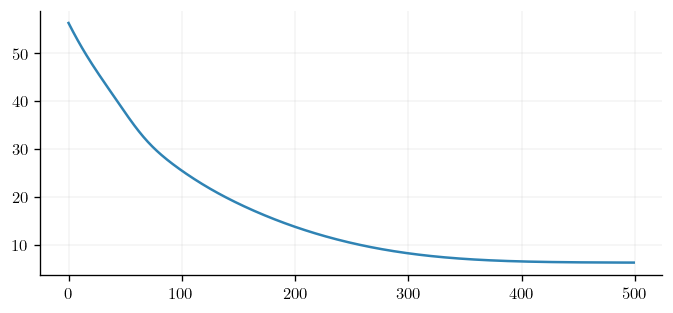

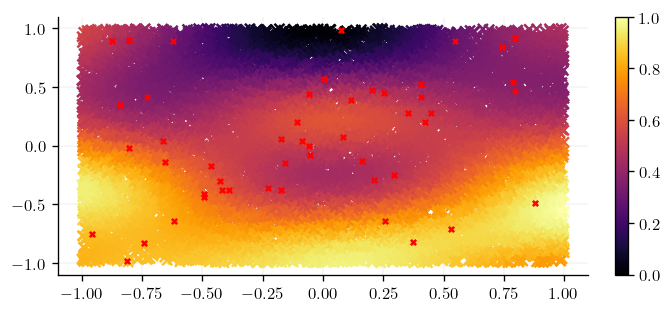

In [4]:
kernel = gpx.kernels.RBF(lengthscale=jnp.array([1.0, 1.0]))
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=0.1)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=jit(gpx.objectives.ConjugateMLL(negative=True)),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=500,
    safe=True,
    key=key,
)
plt.plot(history)

plt.figure()
mean = opt_posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

  0%|          | 0/250 [00:00<?, ?it/s]

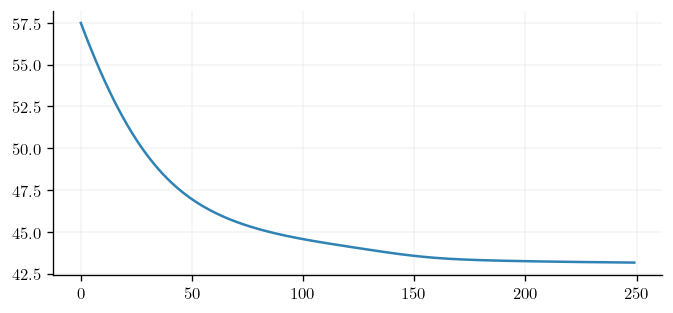

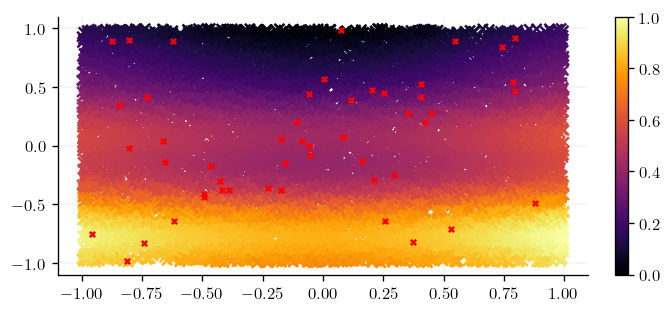

In [5]:
kernel = OrthogonalAdditiveKernel(
    interaction_variances=jnp.array([1.0,1.0]), 
    max_interaction_depth=1,  
    base_kernels = [gpx.kernels.RBF(active_dims=[0]), gpx.kernels.RBF(active_dims=[1])],
    dataset=D
    )
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=0.1)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=250,
    safe=True,
    key=key,
)
plt.plot(history)

plt.figure()
mean = opt_posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

  0%|          | 0/500 [00:00<?, ?it/s]

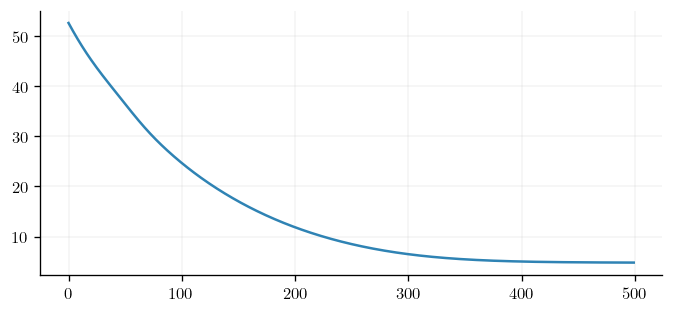

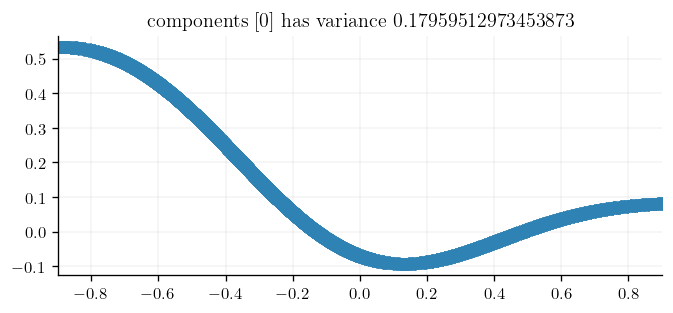

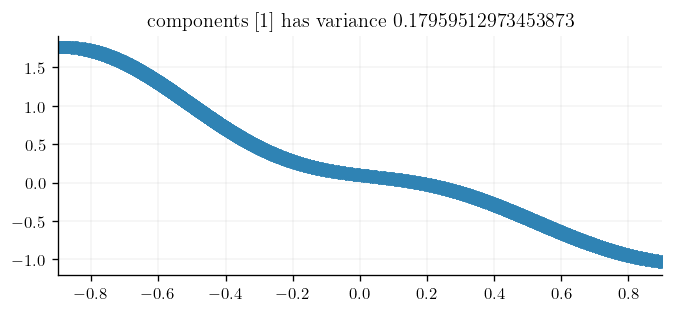

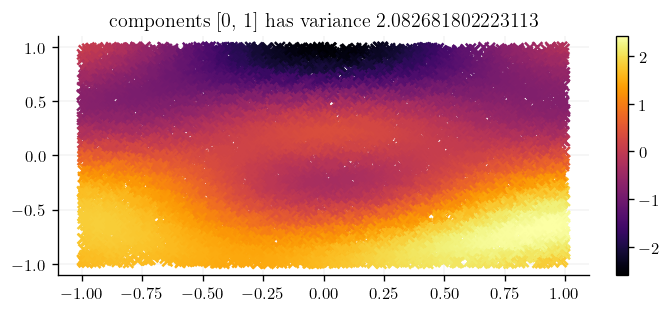

In [6]:
kernel = OrthogonalAdditiveKernel(
    interaction_variances=jnp.array([1.0,1.0, 1.0]), 
    max_interaction_depth=2,  
    base_kernels = [gpx.kernels.RBF(active_dims=[0]), gpx.kernels.RBF(active_dims=[1])],
    dataset=D
    )
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=0.1)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=500,
    safe=True,
    key=key,
)
plt.plot(history)


def plot_posterior_with_components(kernel, components):
    if len(components)>2 or len(components)==0:
        raise ValueError("Can only plot 1D or 2D")
    specific_kernel =  kernel.return_specific_contribution(components)
    specific_posterior= gpx.Prior(mean_function=meanf, kernel=specific_kernel)* likelihood
    mean =  specific_posterior.predict(xplot, D).mean()
    if len(components)==1:
        plt.figure()
        plt.scatter(xplot[:,components[0]], mean)
        plt.title(f"components {components} has variance {kernel.interaction_variances[len(components)]}")
        plt.xlim(-0.9,0.9)
        #plt.scatter(x[:,components[0]],y[:,0], color="red", s=10.0)
    elif len(components)==2:
        plt.figure()
        plt.scatter(xplot[:,0], xplot[:,1], c=mean)
        plt.title(f"components {components} has variance {kernel.interaction_variances[len(components)]}")
        plt.colorbar()
        #plt.scatter(x[:,0], x[:,1], color="red", s=10.0)

plot_posterior_with_components(opt_posterior.prior.kernel, [0])
plot_posterior_with_components(opt_posterior.prior.kernel, [1])
plot_posterior_with_components(opt_posterior.prior.kernel, [0,1])

In [7]:
opt_posterior.prior.kernel.ortho_kernels[0]

OrthogonalKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', base_kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=[0], name='RBF', lengthscale=Array(0.56163154, dtype=float64), variance=Array(1., dtype=float64)), dataset=- Number of observations: 50
- Input dimension: 2
- Output dimension: 1, num_samples=10, key=Array([    0, 12345], dtype=uint32))